<a href="https://colab.research.google.com/github/shuaigezhu/starDist/blob/master/overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import**

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import collections
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from random import randint
import glob
import scipy
import seaborn as sns

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.gpu_device_name()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2983200787886391688
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11817667789
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 4648148941815255612
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:82:00.0, compute capability: 6.0"
]


'/device:GPU:0'

### **Normalizaton**

In [0]:
def Normalization(data):
  ra_max = 60
  ra_min = -50
  ra_range = ra_max - ra_min
  dec_max = 1.26
  dec_min = -1.26
  dec_range = dec_max - dec_min
  mag_min = 0
  mag_max = 25
  mag_range = mag_max - mag_min
  lambda_min = 4000
  lambda_max = 46500
  lambda_range = lambda_max - lambda_min
  
  data_f = data.astype(float)

  data_f['ra'] = data_f['ra'].apply(lambda x: (x - ra_min)/ra_range)
  data_f['dec'] = data_f['dec'].apply(lambda x: (x - dec_min)/dec_range)
  data_f['mag'] = data_f['mag'].apply(lambda x: (x - mag_min)/mag_range)
  data_f['wavelength'] = data_f['wavelength'].apply(lambda x: (x - lambda_min)/lambda_range)

  return data_f

def Normalization_y(data):
    parallax_max = 6
    parallax_min = 0
    parallax_range = parallax_max - parallax_min
    data_f = data.astype(float)
    data_f['parallax'] = data_f['parallax'].apply(lambda x: (x - parallax_min)/parallax_range)
    return data_f

def Normalization_old(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n

### **MLP**

In [0]:
def batch_mlp(input, output_sizes, variable_scope):
  """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).
  
  Args:
    input: input tensor of shape [B,n,d_in].
    output_sizes: An iterable containing the output sizes of the MLP as defined 
        in `basic.Linear`.
    variable_scope: String giving the name of the variable scope. If this is set
        to be the same as a previously defined MLP, then the weights are reused.
    
  Returns:
    tensor of shape [B,n,d_out] where d_out=output_sizes[-1]
  """
  # Get the shapes of the input and reshape to parallelise across observations
  batch_size, _, filter_size = input.shape.as_list()
  output = tf.reshape(input, (-1, filter_size))
  output.set_shape((None, filter_size))

  # Pass through MLP
  with tf.variable_scope(variable_scope, reuse=tf.AUTO_REUSE):
    for i, size in enumerate(output_sizes[:-1]):
      output = tf.nn.dropout(tf.nn.relu(
          tf.layers.dense(output, size, kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.0001), name="layer_{}".format(i))),0.5)

    # Last layer without a ReLu
    output = tf.nn.dropout(tf.layers.dense(
        output, output_sizes[-1], kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.0001), name="layer_{}".format(i + 1)), 0.5)

  # Bring back into original shape
  output = tf.reshape(output, (batch_size, -1, output_sizes[-1]))
  return output

### **Deterministic Encoder**

In [0]:
class DeterministicEncoder(object):
  """The Deterministic Encoder."""

  def __init__(self, output_sizes, attention):
    """(A)NP deterministic encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      attention: The attention module.
    """
    self._output_sizes = output_sizes
    self._attention = attention

  def __call__(self, context_x, context_y, target_x):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.
      target_x: Tensor of shape [B,target_observations,d_x]. 
          For this 1D regression task this corresponds to the x-values.

    Returns:
      The encoded representation. Tensor of shape [B,target_observations,d]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, 
                       "deterministic_encoder")

    # Apply attention
    with tf.variable_scope("deterministic_encoder", reuse=tf.AUTO_REUSE):
        hidden = self._attention(context_x, target_x, hidden)

    return hidden

### **Latent Encoder**

In [0]:
class LatentEncoder(object):
  """The Latent Encoder."""

  def __init__(self, output_sizes, num_latents):
    """(A)NP latent encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
      num_latents: The latent dimensionality.
    """
    self._output_sizes = output_sizes
    self._num_latents = num_latents

  def __call__(self, x, y):
    """Encodes the inputs into one representation.

    Args:
      x: Tensor of shape [B,observations,d_x]. For this 1D regression
          task this corresponds to the x-values.
      y: Tensor of shape [B,observations,d_y]. For this 1D regression
          task this corresponds to the y-values.

    Returns:
      A normal distribution over tensors of shape [B, num_latents]
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([x, y], axis=-1)

    # Pass final axis through MLP
    hidden = batch_mlp(encoder_input, self._output_sizes, "latent_encoder")
      
    # Aggregator: take the mean over all points
    hidden = tf.reduce_mean(hidden, axis=1)
    
    # Have further MLP layers that map to the parameters of the Gaussian latent
    with tf.variable_scope("latent_encoder", reuse=tf.AUTO_REUSE):
      # First apply intermediate relu layer 
      hidden = tf.nn.dropout(tf.nn.relu(
          tf.layers.dense(hidden, 
                          (self._output_sizes[-1] + self._num_latents)/2, 
                          kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.0001),
                          name="penultimate_layer")), 0.5)
      # Then apply further linear layers to output latent mu and log sigma
      mu = tf.nn.dropout(tf.layers.dense(hidden, self._num_latents, kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.0001),name="mean_layer")
                        ,0.5)
      log_sigma = tf.nn.dropout(tf.layers.dense(hidden, self._num_latents,kernel_regularizer= tf.contrib.layers.l2_regularizer(scale=0.0001), name="std_layer")
                                ,0.5)
      
    # Compute sigma
    sigma = 0.1 + 0.9 * tf.sigmoid(log_sigma)

    return tf.contrib.distributions.Normal(loc=mu, scale=sigma)

### **Decoder**

In [0]:
class Decoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """(A)NP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x):
    """Decodes the individual targets.

    Args:
      representation: The representation of the context for target predictions. 
          Tensor of shape [B,target_observations,?].
      target_x: The x locations for the target query.
          Tensor of shape [B,target_observations,d_x].

    Returns:
      dist: A multivariate Gaussian over the target points. A distribution over
          tensors of shape [B,target_observations,d_y].
      mu: The mean of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
      sigma: The standard deviation of the multivariate Gaussian.
          Tensor of shape [B,target_observations,d_x].
    """
    # concatenate target_x and representation
    hidden = tf.concat([representation, target_x], axis=-1)
    
    # Pass final axis through MLP
    hidden = batch_mlp(hidden, self._output_sizes, "decoder")

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tf.contrib.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

### **Model**

In [0]:
class LatentModel(object):
  """The (A)NP model."""

  def __init__(self, latent_encoder_output_sizes, num_latents,
               decoder_output_sizes, use_deterministic_path=True, 
               deterministic_encoder_output_sizes=None, attention=None):
    """Initialises the model.

    Args:
      latent_encoder_output_sizes: An iterable containing the sizes of hidden 
          layers of the latent encoder.
      num_latents: The latent dimensionality.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to d_y * 2
          (it encodes both mean and variance concatenated)
      use_deterministic_path: a boolean that indicates whether the deterministic
          encoder is used or not.
      deterministic_encoder_output_sizes: An iterable containing the sizes of 
          hidden layers of the deterministic encoder. The last one is the size 
          of the deterministic representation r.
      attention: The attention module used in the deterministic encoder.
          Only relevant when use_deterministic_path=True.
    """
    self._latent_encoder = LatentEncoder(latent_encoder_output_sizes, 
                                         num_latents)
    self._decoder = Decoder(decoder_output_sizes)
    self._use_deterministic_path = use_deterministic_path
    if use_deterministic_path:
      self._deterministic_encoder = DeterministicEncoder(
          deterministic_encoder_output_sizes, attention)
    

  def __call__(self, query, num_targets, target_y=None, test_target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Tensor of shape [B,num_contexts,d_x]. 
              Contains the x values of the context points.
          context_y: Tensor of shape [B,num_contexts,d_y]. 
              Contains the y values of the context points.
          target_x: Tensor of shape [B,num_targets,d_x]. 
              Contains the x values of the target points.
      num_targets: Number of target points.
      target_y: The ground truth y values of the target y. 
          Tensor of shape [B,num_targets,d_y].

    Returns:
      log_p: The log_probability of the target_y given the predicted
          distribution. Tensor of shape [B,num_targets].
      mu: The mean of the predicted distribution. 
          Tensor of shape [B,num_targets,d_y].
      sigma: The variance of the predicted distribution.
          Tensor of shape [B,num_targets,d_y].
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    prior = self._latent_encoder(context_x, context_y)
    
    # For training, when target_y is available, use targets for latent encoder.
    # Note that targets contain contexts by design.
    if target_y is None:
      latent_rep = prior.sample()
    # For testing, when target_y unavailable, use contexts for latent encoder.
    else:
      posterior = self._latent_encoder(target_x, target_y)
      latent_rep = posterior.sample()
    latent_rep = tf.tile(tf.expand_dims(latent_rep, axis=1),
                         [1, num_targets, 1])
    if self._use_deterministic_path:
      deterministic_rep = self._deterministic_encoder(context_x, context_y,
                                                      target_x)
      representation = tf.concat([deterministic_rep, latent_rep], axis=-1)
    else:
      representation = latent_rep
      
    dist, mu, sigma = self._decoder(representation, target_x)
    
    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None.
    if target_y is not None:
      log_p = dist.log_prob(target_y)
      posterior = self._latent_encoder(target_x, target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      LL = tf.reduce_mean(log_p, keep_dims=False)
    else:
      log_p = dist.log_prob(test_target_y)
      posterior = self._latent_encoder(target_x, test_target_y)
      kl = tf.reduce_sum(
          tf.contrib.distributions.kl_divergence(posterior, prior), 
          axis=-1, keepdims=True)
      kl = tf.tile(kl, [1, num_targets])
      loss = - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      #validation_context_loss = - tf.reduce_mean(log_p[:,int(0.5*num_targets):] - kl / tf.cast(num_targets, tf.float32))
      #validation_noncontext_loss =  - tf.reduce_mean(log_p - kl / tf.cast(num_targets, tf.float32))
      LL = None
        #con_y = pred_y[:,:int(0.5 * test_num_total_points)] - target_y[:,:int(0.5 * test_num_total_points)]
      #tar_y = pred_y[:,int(0.5 * test_num_total_points):] - target_y[:,int(0.5 * test_num_total_points):]

    return mu, sigma, log_p, LL, kl, loss

### **Attention**

In [0]:
def uniform_attention(q, v):
  """Uniform attention. Equivalent to np.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    v: values. tensor of shape [B,n,d_v].
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  total_points = tf.shape(q)[1]
  rep = tf.reduce_mean(v, axis=1, keepdims=True)  # [B,1,d_v]
  rep = tf.tile(rep, [1, total_points, 1])
  return rep

def laplace_attention(q, k, v, scale, normalise):
  """Computes laplace exponential attention.

  Args:
    q: queries. tensor of shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    scale: float that scales the L1 distance.
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  k = tf.expand_dims(k, axis=1)  # [B,1,n,d_k]
  q = tf.expand_dims(q, axis=2)  # [B,m,1,d_k]
  unnorm_weights = - tf.abs((k - q) / scale)  # [B,m,n,d_k]
  unnorm_weights = tf.reduce_sum(unnorm_weights, axis=-1)  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = lambda x: 1 + tf.tanh(x)
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def dot_product_attention(q, k, v, normalise):
  """Computes dot product attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    normalise: Boolean that determines whether weights sum to 1.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = tf.shape(q)[-1]
  scale = tf.sqrt(tf.cast(d_k, tf.float32))
  unnorm_weights = tf.einsum('bjk,bik->bij', k, q) / scale  # [B,m,n]
  if normalise:
    weight_fn = tf.nn.softmax
  else:
    weight_fn = tf.sigmoid
  weights = weight_fn(unnorm_weights)  # [B,m,n]
  rep = tf.einsum('bik,bkj->bij', weights, v)  # [B,m,d_v]
  return rep


def multihead_attention(q, k, v, num_heads=8):
  """Computes multi-head attention.

  Args:
    q: queries. tensor of  shape [B,m,d_k].
    k: keys. tensor of shape [B,n,d_k].
    v: values. tensor of shape [B,n,d_v].
    num_heads: number of heads. Should divide d_v.
    
  Returns:
    tensor of shape [B,m,d_v].
  """
  d_k = q.get_shape().as_list()[-1]
  d_v = v.get_shape().as_list()[-1]
  head_size = d_v / num_heads
  key_initializer = tf.random_normal_initializer(stddev=d_k**-0.5)
  value_initializer = tf.random_normal_initializer(stddev=d_v**-0.5)
  rep = tf.constant(0.0)
  for h in range(num_heads):
    o = dot_product_attention(
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wq%d' % h, use_bias=False, padding='VALID')(q),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wk%d' % h, use_bias=False, padding='VALID')(k),
        tf.layers.Conv1D(head_size, 1, kernel_initializer=key_initializer,
                   name='wv%d' % h, use_bias=False, padding='VALID')(v),
        normalise=True)
    rep += tf.layers.Conv1D(d_v, 1, kernel_initializer=value_initializer,
                      name='wo%d' % h, use_bias=False, padding='VALID')(o)
  return rep

class Attention(object):
  """The Attention module."""

  def __init__(self, rep, output_sizes, att_type, scale=1., normalise=True,
               num_heads=8):
    """Create attention module.

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.
    Args:
      rep: transformation to apply to contexts before computing attention. 
          One of: ['identity','mlp'].
      output_sizes: list of number of hidden units per layer of mlp.
          Used only if rep == 'mlp'.
      att_type: type of attention. One of the following:
          ['uniform','laplace','dot_product','multihead']
      scale: scale of attention.
      normalise: Boolean determining whether to:
          1. apply softmax to weights so that they sum to 1 across context pts or
          2. apply custom transformation to have weights in [0,1].
      num_heads: number of heads for multihead.
    """
    self._rep = rep
    self._output_sizes = output_sizes
    self._type = att_type
    self._scale = scale
    self._normalise = normalise
    if self._type == 'multihead':
      self._num_heads = num_heads

  def __call__(self, x1, x2, r):
    """Apply attention to create aggregated representation of r.

    Args:
      x1: tensor of shape [B,n1,d_x].
      x2: tensor of shape [B,n2,d_x].
      r: tensor of shape [B,n1,d].
      
    Returns:
      tensor of shape [B,n2,d]

    Raises:
      NameError: The argument for rep/type was invalid.
    """
    if self._rep == 'identity':
      k, q = (x1, x2)
    elif self._rep == 'mlp':
      # Pass through MLP
      k = batch_mlp(x1, self._output_sizes, "attention")
      q = batch_mlp(x2, self._output_sizes, "attention")
    else:
      raise NameError("'rep' not among ['identity','mlp']")

    if self._type == 'uniform':
      rep = uniform_attention(q, r)
    elif self._type == 'laplace':
      rep = laplace_attention(q, k, r, self._scale, self._normalise)
    elif self._type == 'dot_product':
      rep = dot_product_attention(q, k, r, self._normalise)
    elif self._type == 'multihead':
      rep = multihead_attention(q, k, r, self._num_heads)
    else:
      raise NameError(("'att_type' not among ['uniform','laplace','dot_product'"
                       ",'multihead']"))

    return rep

### **Data wrapper**

In [0]:
def datawrap(data_x, data_y, batch_size):
  num_target = 0
  num_context = 50
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)[:,:num_context+num_target,:]
  target_y = np.array(batch_datay)[:,:num_context+num_target,:]
  
    #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = num_context+num_target
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

def testdatawrap(data_x, data_y, batch_size):
  num_target = 50
  num_context = int(0.5 * batch_size)
  batch_num = int(data_x.shape[0]/batch_size)
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    batch_datax.append(tmp)
    tmp = data_y[locations,:]
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]#context is belong to target
  context_y = np.array(batch_datay)[:,:num_context,:]
  target_x = np.array(batch_datax)#x values
  target_y = np.array(batch_datay)#y values
  
  #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = tf.convert_to_tensor(target_y, np.float32)
  
  query = ((context_x, context_y), target_x)
  num_total_points = batch_size 
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

### **Data selector**

In [0]:
# input your filename (csv.)
filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/all_gaia2.csv"
df = pd.read_csv(filename)
# cuts 
gaia_selected = df.loc[(df['parallax_error'] <= 0.1) 
                       & (df['parallax'] <= 4) & (df['parallax'] >= 0)]
#gaia_selected = df.loc[(df['visibility_periods_used'] >= 8) & (df['parallax_error'] <= 0.1) &
                       #((df['astrometric_chi2_al']/np.sqrt(df['astrometric_n_good_obs_al'] - 5))<=35) 
                       #& (df['parallax'] <= 4) & (df['parallax'] >= 1)]
gaia_selected.shape

(522982, 94)

### Distribution

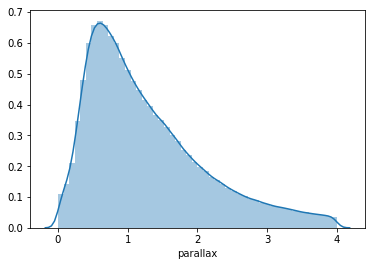

In [0]:
sns.distplot(gaia_selected['parallax'])

### **Data processsing**

In [0]:
#{ra, dec, phot_g_mean_mag, g_lambda}
#{ra, dec, phot_bp_mean_mag, bp_lambda}
#{ra, dec, phot_rp_mean_mag, rp_lambda}

# 1. split into 3 df with 3 fluxes
g_mag = gaia_selected.loc[:, ['ra', 'dec','phot_g_mean_mag', 'parallax']]
g_mag = g_mag.rename(columns={'phot_g_mean_mag':"mag"})
g_mag = g_mag.dropna()

bp_mag = gaia_selected.loc[:, ['ra', 'dec','phot_bp_mean_mag', 'parallax']]
bp_mag = bp_mag.dropna()
bp_mag = bp_mag.rename(columns={'phot_bp_mean_mag':"mag"})

rp_mag = gaia_selected.loc[:, ['ra', 'dec','phot_rp_mean_mag', 'parallax']]
rp_mag = rp_mag.dropna()
rp_mag = rp_mag.rename(columns={'phot_rp_mean_mag':"mag"})

# 2. add lambda into dfs
g_mag ['wavelength'] = 5858
bp_mag ['wavelength'] = 5044
rp_mag ['wavelength'] = 7692

# 3. append three dfs into one
new_df = g_mag.append(bp_mag)
new_df = new_df.append(rp_mag)

#split into x_y
x_df = new_df.loc[:,['ra', 'dec','mag', 'wavelength']]
y_df = new_df.loc[:,['parallax']]

#split into train and validation
ratio = 0.99 #the ratio is train/all 
msk = np.random.rand(len(x_df)) < ratio
train_x = x_df[msk]
train_y = y_df[msk]
test_x = x_df[~msk]
test_y = y_df[~msk]

locations = np.random.choice(train_x.shape[0],
                                 size=300000,
                                 replace=False)

train_norm_x = Normalization_old(np.array(train_x))
test_norm_x = Normalization_old(np.array(test_x))

test_norm_y = Normalization_old(np.array(test_y))
train_norm_y = Normalization_old(np.array(train_y))
#[locations,:]
train_norm_x = np.array(train_norm_x).astype(float)[locations,:]
train_norm_y = np.array(train_norm_y).astype(float)[locations,:]
test_norm_x = np.array(test_norm_x).astype(float)
test_norm_y = np.array(test_norm_y).astype(float)

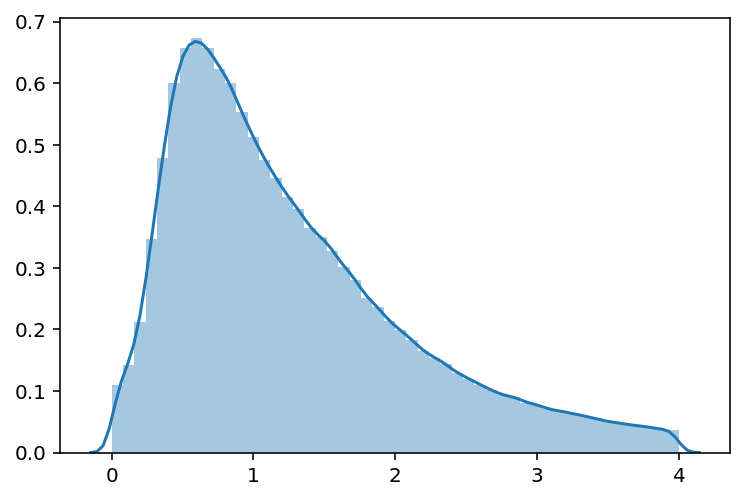

In [0]:
sns.distplot(train_y)

In [0]:
# size of train and test set
print(train_norm_x.shape)
print(test_norm_x.shape)

(300000, 4)
(15504, 4)


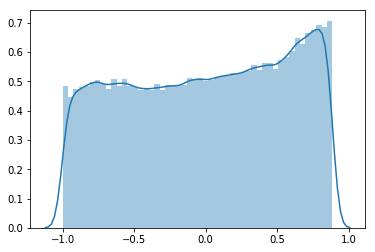

In [0]:
# distribution of ra
sns.distplot(train_norm_x[:,0])

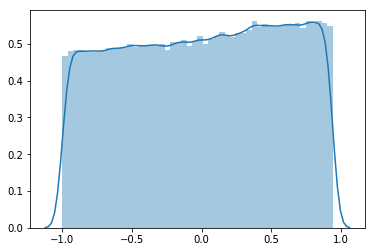

In [0]:
# dec
sns.distplot(train_norm_x[:,1])

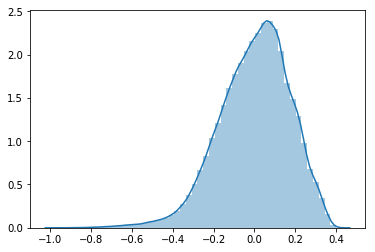

In [0]:
# mag
sns.distplot(train_norm_x[:,2])

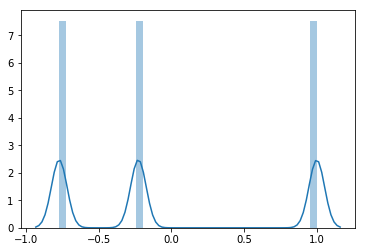

In [0]:
# lambda
sns.distplot(train_norm_x[:,3])

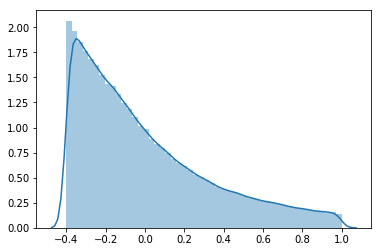

In [0]:
sns.distplot(train_norm_y)

### **Panstarrs datawrapper**

In [0]:
def pan_testdatawrap(data_x, data_y, pan_x, batch_size):
# data_x: gaia_x,  data_y: gaia_y
# context x are gaia_x, context y are gaia_y.
# target x are (gaia_x + panstarrs_x), target y are none.
  num_target = 50
  num_context =  data_x.shape[0]
  batch_num = 1
  batch_datax = []
  batch_datay = []
  for i in range(batch_num):
    locations = np.random.choice(data_x.shape[0],
                                 size=batch_size,
                                 replace=False)
    tmp = data_x[locations,:]
    tmp = np.append(tmp, pan_x, axis=0) # gaia_x + panstarrs_x
    batch_datax.append(tmp)
    tmp = data_y[locations,:] # only gaia_y
    batch_datay.append(tmp)
    #finish batching
  context_x = np.array(batch_datax)[:,:num_context,:]#extract gaia_x as context set #context is belong to target
  context_y = np.array(batch_datay)
  target_x = np.array(batch_datax)#x values (gaia+panstarrs)
  target_y = None #y values
  
  #convert to tensor TF from np array
  context_x = tf.convert_to_tensor(context_x, np.float32)
  context_y = tf.convert_to_tensor(context_y, np.float32)
  target_x = tf.convert_to_tensor(target_x, np.float32)
  target_y = None
  
  query = ((context_x, context_y), target_x)
  num_total_points = target_x.shape[1] 
  num_context_points = num_context
  return query, target_y, num_total_points, num_context_points

### **Panstarrs data processing** 

In [0]:
#process Panstarr
#read 5 panstarrs files
#rename column and add lambda
#g
pan_g_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_g_yufengzhu.csv"
pan_g_df = pd.read_csv(pan_g_filename)
pan_g_df = pan_g_df.rename(columns={'gra':"ra", 'gdec':"dec", 'graErr':"raErr", 'gdecErr':"decErr", 'gPSFMag':"mag",
                                   'gPSFMagErr':"PSFMagErr", 'gApMag':"ApMag", 'gApMagErr':"ApMagErr", 
                                    'gKronMag':"KronMag", 'gKronMagErr':"KronMagErr", 'gEpoch':"Epoch"})
pan_g_df['wavelength'] = 4810
#print(pan_g_df.head())

#i
pan_i_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_i_yufengzhu.csv"
pan_i_df = pd.read_csv(pan_i_filename)
pan_i_df = pan_i_df.rename(columns={'ira':"ra", 'idec':"dec", 'iraErr':"raErr", 'idecErr':"decErr", 'iPSFMag':"mag",
                                   'iPSFMagErr':"PSFMagErr", 'iApMag':"ApMag", 'iApMagErr':"ApMagErr", 
                                    'iKronMag':"KronMag", 'iKronMagErr':"KronMagErr", 'iEpoch':"Epoch"})
pan_i_df['wavelength'] = 7503

#r
pan_r_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_r_yufengzhu.csv"
pan_r_df = pd.read_csv(pan_r_filename)
pan_r_df = pan_r_df.rename(columns={'rra':"ra", 'rdec':"dec", 'rraErr':"raErr", 'rdecErr':"decErr", 'rPSFMag':"mag",
                                   'rPSFMagErr':"PSFMagErr", 'rApMag':"ApMag", 'rApMagErr':"ApMagErr", 
                                    'rKronMag':"KronMag", 'rKronMagErr':"KronMagErr", 'rEpoch':"Epoch"})
pan_r_df['wavelength'] = 6156

#y
pan_y_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_y_yufengzhu.csv"
pan_y_df = pd.read_csv(pan_y_filename)
pan_y_df = pan_y_df.rename(columns={'yra':"ra", 'ydec':"dec", 'yraErr':"raErr", 'ydecErr':"decErr", 'yPSFMag':"mag",
                                   'yPSFMagErr':"PSFMagErr", 'yApMag':"ApMag", 'yApMagErr':"ApMagErr", 
                                    'yKronMag':"KronMag", 'yKronMagErr':"KronMagErr", 'yEpoch':"Epoch"})
pan_y_df['wavelength'] = 9644

#z
pan_z_filename = "/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/Panstarrs/panstarrs_z_yufengzhu.csv"
pan_z_df = pd.read_csv(pan_z_filename)
pan_z_df = pan_z_df.rename(columns={'zra':"ra", 'zdec':"dec", 'zraErr':"raErr", 'zdecErr':"decErr", 'zPSFMag':"mag",
                                   'zPSFMagErr':"PSFMagErr", 'zApMag':"ApMag", 'zApMagErr':"ApMagErr", 
                                    'zKronMag':"KronMag", 'zKronMagErr':"KronMagErr", 'zEpoch':"Epoch"})
pan_z_df['wavelength'] = 8668

#append 5 dfs
pan_df = pan_g_df.append(pan_i_df)
pan_df = pan_df.append(pan_r_df)
pan_df = pan_df.append(pan_y_df)
pan_df = pan_df.append(pan_z_df)
pan_df.head()

,objID,ra,raErr,dec,decErr,mag,PSFMagErr,ApMag,ApMagErr,KronMag,KronMagErr,Epoch,wavelength
0,107400000074469042,0.007456,0.021533,-0.492763,0.020465,21.650600,0.044576,21.636200,0.007448,21.717100,0.066432,56045.493089,4810
1,107400003876815060,0.387671,0.098669,-0.496136,0.093997,23.397100,0.199889,23.325399,0.017216,23.721901,0.352384,55973.689348,4810
2,107400004035136929,0.403500,0.008196,-0.494602,0.007885,20.184999,0.014118,20.078699,0.003860,20.171400,0.019513,55973.689348,4810
3,107400004486547480,0.448660,0.080845,-0.494098,0.077017,23.124500,0.163781,23.685200,0.020318,23.889299,0.429861,55973.689348,4810
4,107400004615655920,0.461519,0.073174,-0.495389,0.069709,22.594900,0.148240,23.051201,0.015173,23.094000,0.299518,55973.689348,4810


In [0]:
#selected attributes
selectedf = ['ra', 'dec', 'mag', 'wavelength']
pan_selected_df = pan_df.loc[:, selectedf]
pan_selected_df.head()

,ra,dec,mag,wavelength
0,0.007456,-0.492763,21.650600,4810
1,0.387671,-0.496136,23.397100,4810
2,0.403500,-0.494602,20.184999,4810
3,0.448660,-0.494098,23.124500,4810
4,0.461519,-0.495389,22.594900,4810


In [0]:
locations = np.random.choice(pan_selected_df.shape[0],
                                 size=5000,
                                 replace=False)

pan_target_x = Normalization(pan_selected_df)
pan_target_x = np.array(pan_target_x)[locations,:]
pd.DataFrame(pan_target_x).head()

,0,1,2,3
0,0.480470,0.494630,0.920660,0.050729
1,0.785050,0.395486,0.856996,0.050729
2,0.832679,0.352825,0.882700,0.109835
3,0.592226,0.682169,0.883536,0.109835
4,0.807871,0.369061,0.886020,0.019059


### **Gaia Main**

start wrapping data...
start wrapping training data...
finish...
start wrapping testing data
finish wrapping data...
start doing prediction...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt/model.ckpt-0
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt/model.ckpt.
INFO:tensorflow:Restoring parameters from /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt/model.ckpt-0


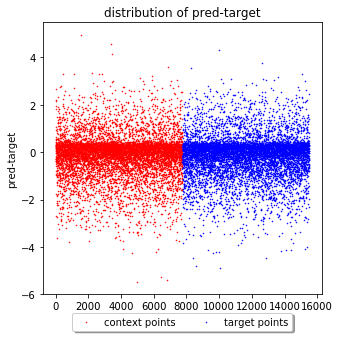

Iteration: 0, train_loss: 2.776893377304077
Iteration: 0, validation_loss: 2.301936149597168
INFO:tensorflow:global_step/sec: 2.11411


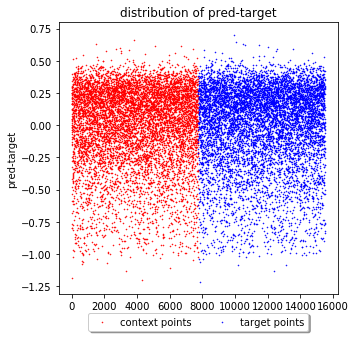

Iteration: 100, train_loss: 0.61599200963974
Iteration: 100, validation_loss: 0.6151294708251953
INFO:tensorflow:global_step/sec: 2.58832


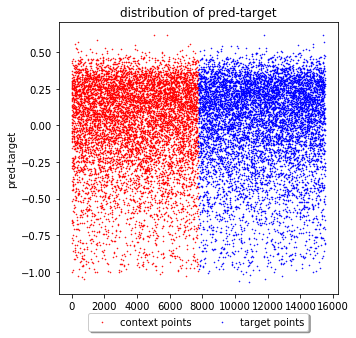

Iteration: 200, train_loss: 0.524519145488739
Iteration: 200, validation_loss: 0.5260254144668579
INFO:tensorflow:global_step/sec: 2.37077


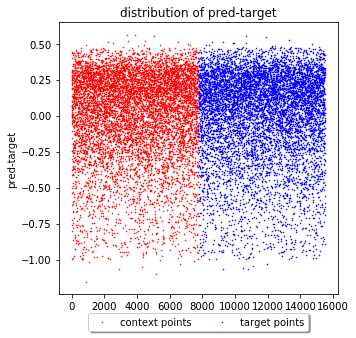

Iteration: 300, train_loss: 0.482256680727005
Iteration: 300, validation_loss: 0.488477498292923
INFO:tensorflow:global_step/sec: 2.24288


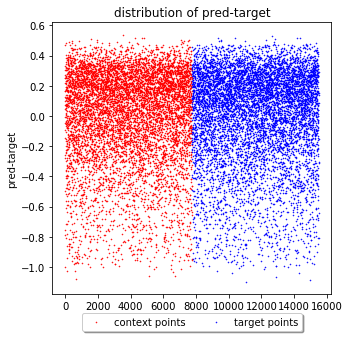

Iteration: 400, train_loss: 0.4762079119682312
Iteration: 400, validation_loss: 0.4766819179058075
INFO:tensorflow:global_step/sec: 2.71287


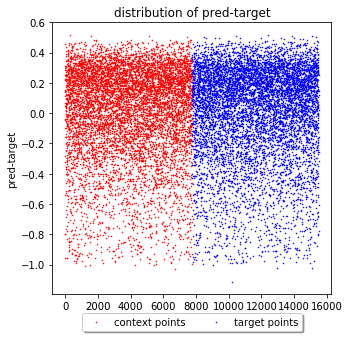

Iteration: 500, train_loss: 0.4731307327747345
Iteration: 500, validation_loss: 0.47868454456329346
INFO:tensorflow:global_step/sec: 2.48919


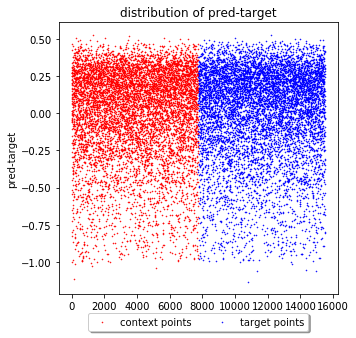

Iteration: 600, train_loss: 0.4713219404220581
Iteration: 600, validation_loss: 0.4732203781604767
INFO:tensorflow:global_step/sec: 2.04897


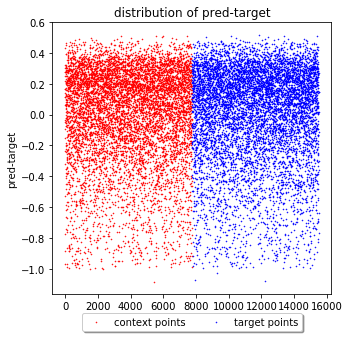

Iteration: 700, train_loss: 0.47047948837280273
Iteration: 700, validation_loss: 0.47477465867996216
INFO:tensorflow:global_step/sec: 2.19283


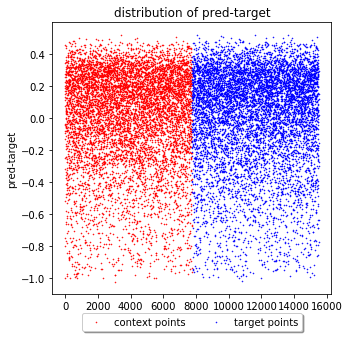

Iteration: 800, train_loss: 0.4693986475467682
Iteration: 800, validation_loss: 0.4746362566947937
INFO:tensorflow:global_step/sec: 2.64657


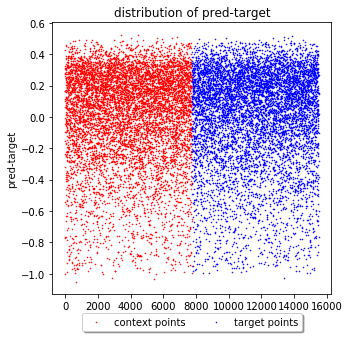

Iteration: 900, train_loss: 0.4689708352088928
Iteration: 900, validation_loss: 0.47402697801589966
INFO:tensorflow:global_step/sec: 2.20129


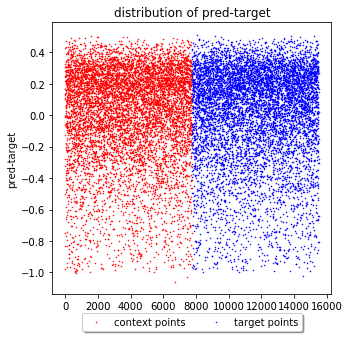

Iteration: 1000, train_loss: 0.46694615483283997
Iteration: 1000, validation_loss: 0.47227829694747925
INFO:tensorflow:global_step/sec: 2.34287


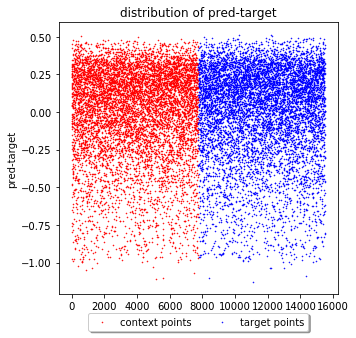

Iteration: 1100, train_loss: 0.4648570716381073
Iteration: 1100, validation_loss: 0.4681171476840973
INFO:tensorflow:global_step/sec: 2.49403


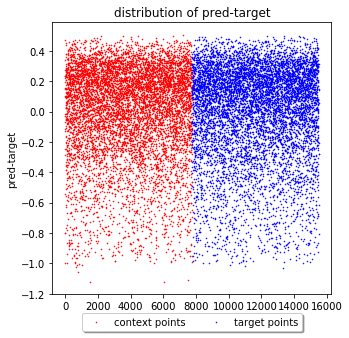

Iteration: 1200, train_loss: 0.46526384353637695
Iteration: 1200, validation_loss: 0.4749987721443176
INFO:tensorflow:global_step/sec: 2.31839


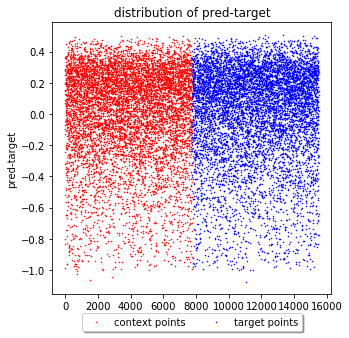

Iteration: 1300, train_loss: 0.4649572968482971
Iteration: 1300, validation_loss: 0.46688613295555115
INFO:tensorflow:global_step/sec: 2.71154


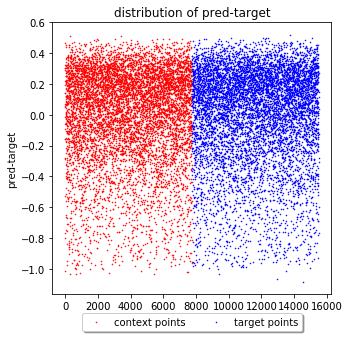

Iteration: 1400, train_loss: 0.4622619152069092
Iteration: 1400, validation_loss: 0.4701274335384369
INFO:tensorflow:Saving checkpoints for 1402 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.79768


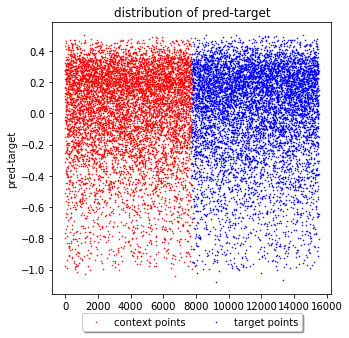

Iteration: 1500, train_loss: 0.4630667567253113
Iteration: 1500, validation_loss: 0.4724082350730896
INFO:tensorflow:global_step/sec: 2.24765


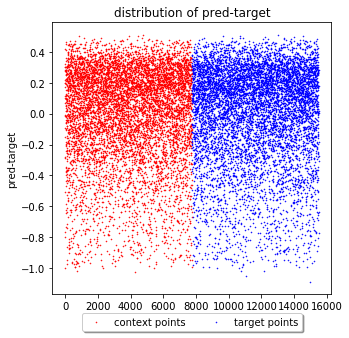

Iteration: 1600, train_loss: 0.46082282066345215
Iteration: 1600, validation_loss: 0.4685972034931183
INFO:tensorflow:global_step/sec: 2.47265


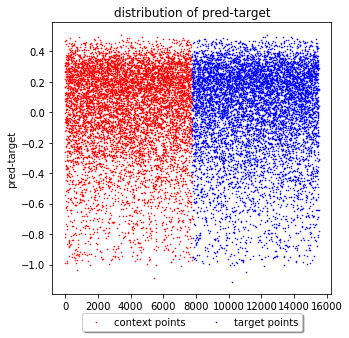

Iteration: 1700, train_loss: 0.46086379885673523
Iteration: 1700, validation_loss: 0.4701683223247528
INFO:tensorflow:global_step/sec: 2.35337


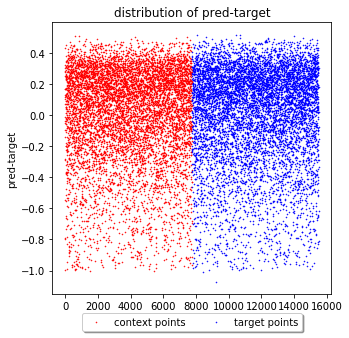

Iteration: 1800, train_loss: 0.46051791310310364
Iteration: 1800, validation_loss: 0.46564823389053345
INFO:tensorflow:global_step/sec: 2.7225


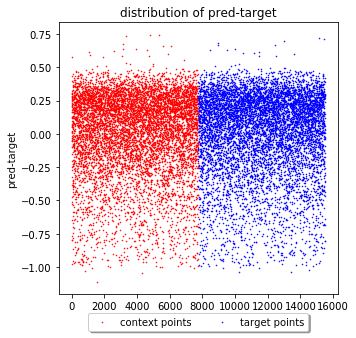

Iteration: 1900, train_loss: 0.45201927423477173
Iteration: 1900, validation_loss: 0.45689934492111206
INFO:tensorflow:global_step/sec: 2.51203


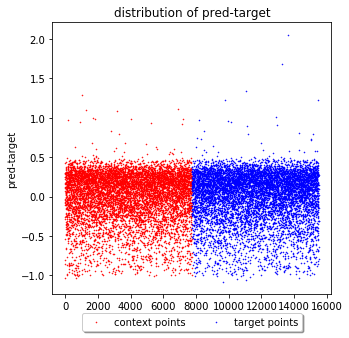

Iteration: 2000, train_loss: 0.4480099081993103
Iteration: 2000, validation_loss: 0.46381983160972595
INFO:tensorflow:global_step/sec: 2.47992


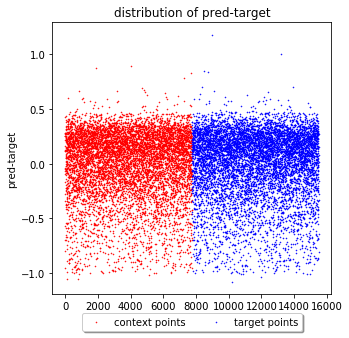

Iteration: 2100, train_loss: 0.4436137080192566
Iteration: 2100, validation_loss: 0.45132923126220703
INFO:tensorflow:global_step/sec: 2.36038


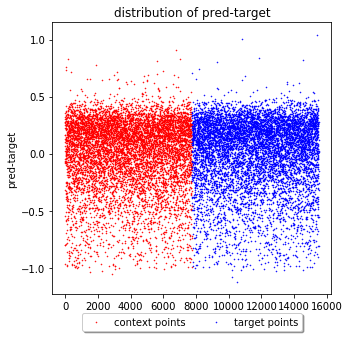

Iteration: 2200, train_loss: 0.4379156231880188
Iteration: 2200, validation_loss: 0.463034451007843
INFO:tensorflow:global_step/sec: 2.70972


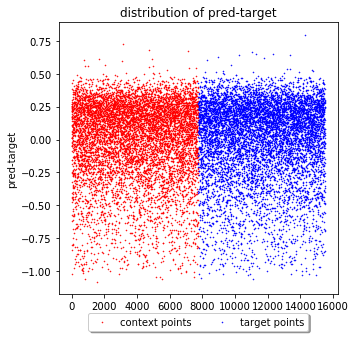

Iteration: 2300, train_loss: 0.4308774471282959
Iteration: 2300, validation_loss: 0.44564056396484375
INFO:tensorflow:global_step/sec: 2.07487


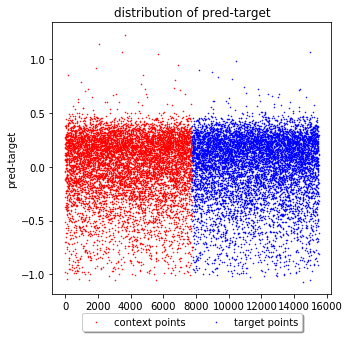

Iteration: 2400, train_loss: 0.4281530976295471
Iteration: 2400, validation_loss: 0.4572678804397583
INFO:tensorflow:global_step/sec: 2.40182


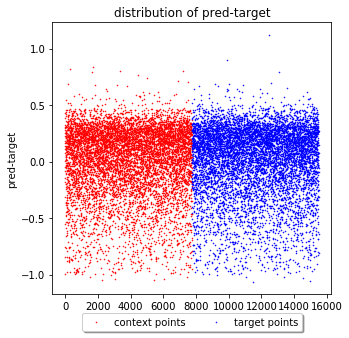

Iteration: 2500, train_loss: 0.4241768717765808
Iteration: 2500, validation_loss: 0.4584228992462158
INFO:tensorflow:global_step/sec: 2.01338


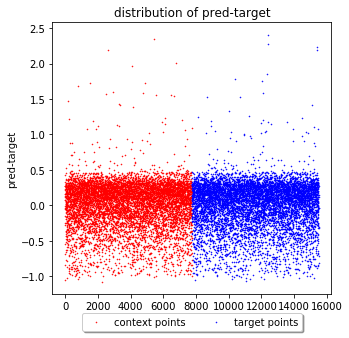

Iteration: 2600, train_loss: 0.41776323318481445
Iteration: 2600, validation_loss: 0.4745285212993622
INFO:tensorflow:global_step/sec: 2.32072


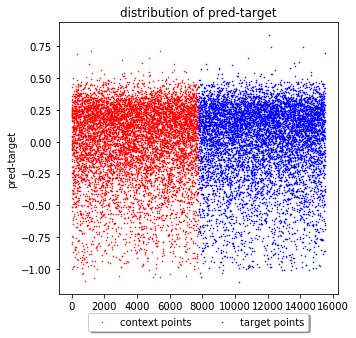

Iteration: 2700, train_loss: 0.41143983602523804
Iteration: 2700, validation_loss: 0.4672507643699646
INFO:tensorflow:global_step/sec: 2.73314


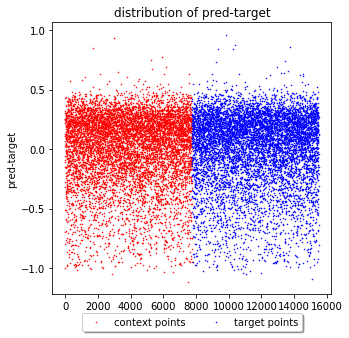

Iteration: 2800, train_loss: 0.40834882855415344
Iteration: 2800, validation_loss: 0.4656974971294403
INFO:tensorflow:Saving checkpoints for 2831 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 2.04802


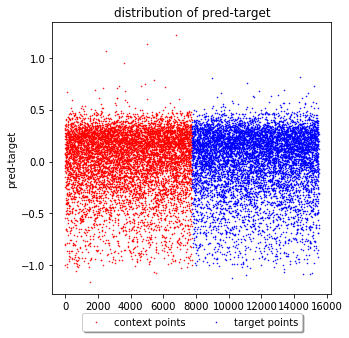

Iteration: 2900, train_loss: 0.40181735157966614
Iteration: 2900, validation_loss: 0.4597603976726532
INFO:tensorflow:global_step/sec: 2.04273


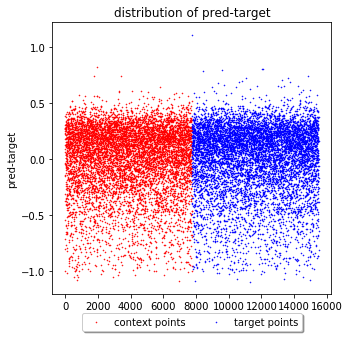

Iteration: 3000, train_loss: 0.3990616500377655
Iteration: 3000, validation_loss: 0.46615269780158997
INFO:tensorflow:global_step/sec: 2.6365


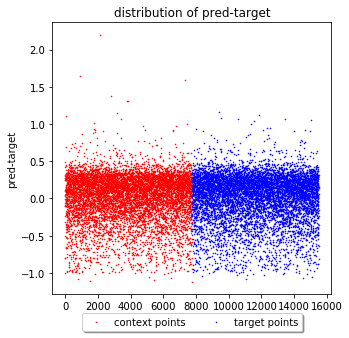

Iteration: 3100, train_loss: 0.3927026093006134
Iteration: 3100, validation_loss: 0.4776599407196045
INFO:tensorflow:global_step/sec: 2.72418


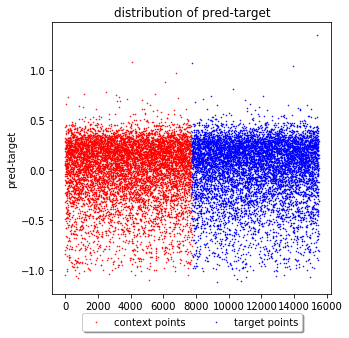

Iteration: 3200, train_loss: 0.3858153820037842
Iteration: 3200, validation_loss: 0.4695426821708679
INFO:tensorflow:global_step/sec: 2.6425


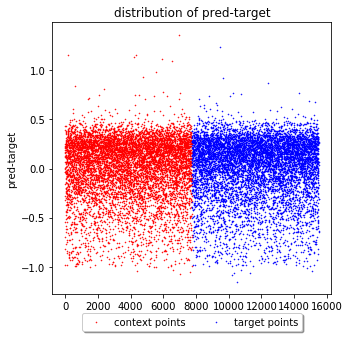

Iteration: 3300, train_loss: 0.37966105341911316
Iteration: 3300, validation_loss: 0.4645633399486542
INFO:tensorflow:global_step/sec: 2.67981


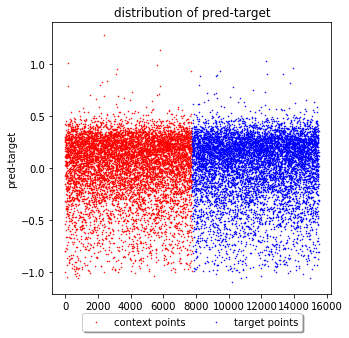

Iteration: 3400, train_loss: 0.37193790078163147
Iteration: 3400, validation_loss: 0.4707096219062805
INFO:tensorflow:global_step/sec: 2.32329


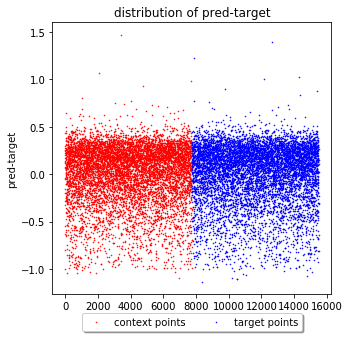

Iteration: 3500, train_loss: 0.3662709891796112
Iteration: 3500, validation_loss: 0.4693954885005951
INFO:tensorflow:global_step/sec: 2.44501


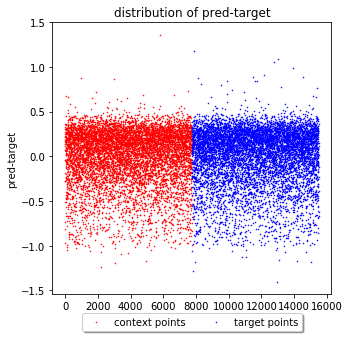

Iteration: 3600, train_loss: 0.36007049679756165
Iteration: 3600, validation_loss: 0.47733962535858154
INFO:tensorflow:global_step/sec: 2.54857


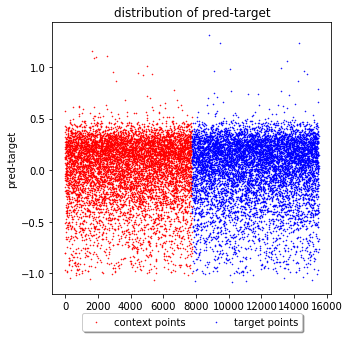

Iteration: 3700, train_loss: 0.354963481426239
Iteration: 3700, validation_loss: 0.4728220999240875
INFO:tensorflow:global_step/sec: 2.62229


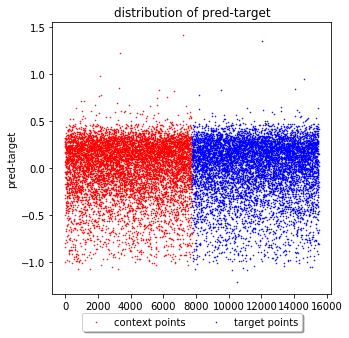

Iteration: 3800, train_loss: 0.350515753030777
Iteration: 3800, validation_loss: 0.4656580686569214
INFO:tensorflow:global_step/sec: 2.54667


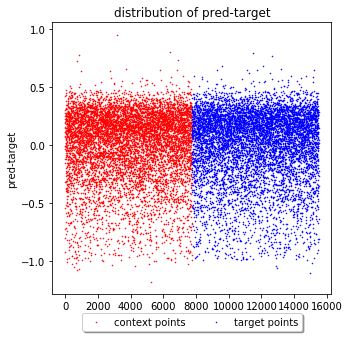

Iteration: 3900, train_loss: 0.3467096984386444
Iteration: 3900, validation_loss: 0.46801820397377014
INFO:tensorflow:global_step/sec: 2.28802


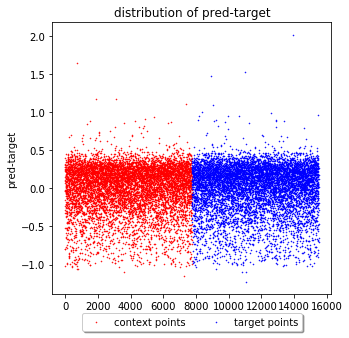

Iteration: 4000, train_loss: 0.3457586169242859
Iteration: 4000, validation_loss: 0.46458899974823
INFO:tensorflow:global_step/sec: 2.21946


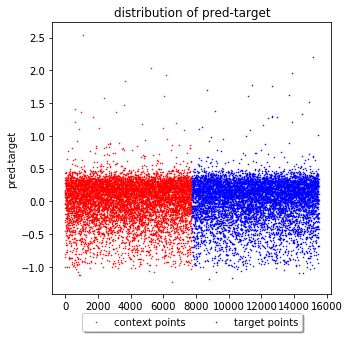

Iteration: 4100, train_loss: 0.33823269605636597
Iteration: 4100, validation_loss: 0.4683506488800049
INFO:tensorflow:global_step/sec: 2.41129


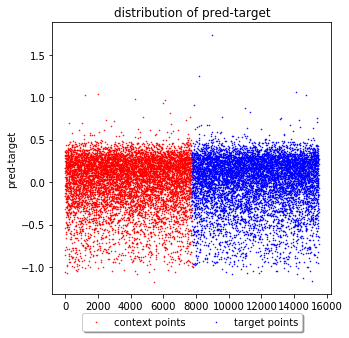

Iteration: 4200, train_loss: 0.33820298314094543
Iteration: 4200, validation_loss: 0.47232669591903687
INFO:tensorflow:Saving checkpoints for 4288 into /home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt/model.ckpt.
INFO:tensorflow:global_step/sec: 1.9577


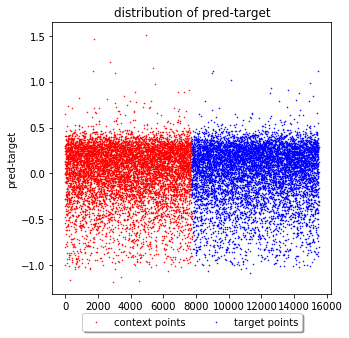

Iteration: 4300, train_loss: 0.3349604308605194
Iteration: 4300, validation_loss: 0.47383034229278564
INFO:tensorflow:global_step/sec: 2.36839


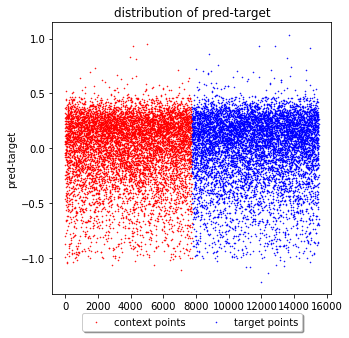

Iteration: 4400, train_loss: 0.3339099884033203
Iteration: 4400, validation_loss: 0.470065176486969
INFO:tensorflow:global_step/sec: 2.38744


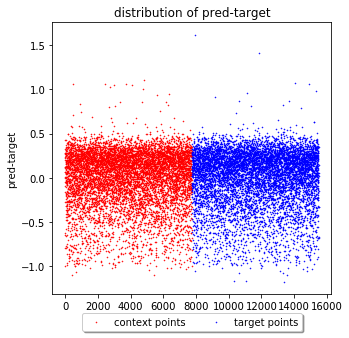

Iteration: 4500, train_loss: 0.33247673511505127
Iteration: 4500, validation_loss: 0.49208104610443115


In [0]:
#from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
#from tensorboardcolab import *
#tbc=TensorBoardColab(startup_waiting_time=30)

TRAINING_ITERATIONS = 5000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 100 #@param {type:"number"}
HIDDEN_SIZE = 64 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)
print("start wrapping data...")
# Define data
#batch_size = 50
batch_size = 50
print("start wrapping training data...")
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)
print("finish...")
print("start wrapping testing data")
test_query, test_target_y, test_num_total_points, test_num_context_points = testdatawrap(test_norm_x, test_norm_y, test_norm_x.shape[0])
print("finish wrapping data...")
# Define the loss
_, _, log_prob, LL, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)

# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _, validation_loss = model(test_query, test_num_total_points, test_target_y = test_target_y)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-3)
global_step = tf.train.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)
init = tf.initialize_all_variables()

LL_set = []
LL_set_x = []
train_losses, test_losses = [],[]
saver = tf.train.Saver(max_to_keep=1)
print("start doing prediction...")
# Train and plot
with tf.train.MonitoredTrainingSession(checkpoint_dir="/home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt", save_checkpoint_secs=600) as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state("/home/yufeng/projects/rrg-kyi/yufeng/gaia/model/test_model.ckpt")
    
  if ckpt and ckpt.model_checkpoint_path:
            # Restores from checkpoint
    saver.restore(sess, ckpt.model_checkpoint_path)
  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])
    
    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      validation_loss_value, loss_value, pred_y, std_y, target_y, whole_query, LL_value = sess.run(
          [validation_loss, loss, mu, sigma, test_target_y, 
           test_query, LL])
      #print("The accuracy is .....")
      accuracy = abs((pred_y-target_y)/target_y)
      accuracy = np.reshape(accuracy, accuracy.shape[1])
      #print(np.mean(accuracy))
    
      # record LL in each itr
      LL_set.append(LL_value)
      #LL_set_X.append(itr)
  
      plt.figure(figsize=(5,5)) 
      con_y = pred_y[:,:int(0.5 * test_num_total_points)] - target_y[:,:int(0.5 * test_num_total_points)]
      tar_y = pred_y[:,int(0.5 * test_num_total_points):] - target_y[:,int(0.5 * test_num_total_points):]
      X1 = np.arange(int(0.5 * test_num_total_points))
      X2 = np.arange(int(0.5 * test_num_total_points),test_num_total_points)
      s_con = plt.scatter(X1,con_y,color='red',s=0.3,label='context points')
      s_tar = plt.scatter(X2,tar_y,color='blue',s=0.3,label='target points')
      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
      plt.xlabel('')
      plt.ylabel('pred-target')
      plt.title(r'distribution of pred-target')
      plt.show()
     
      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, train_loss: {}'.format(it, loss_value))
      print('Iteration: {}, validation_loss: {}'.format(it, validation_loss_value))
      train_losses.append(loss_value)
      test_losses.append(validation_loss_value)
      #tbc.save_value("Loss", "train_loss", it, loss_value)
      #tbc.save_value("Loss", "validation_loss", it, validation_loss_value)

#tbc.flush_line("train_loss")
#tbc.flush_line("validation_loss")
#tbc.close()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)


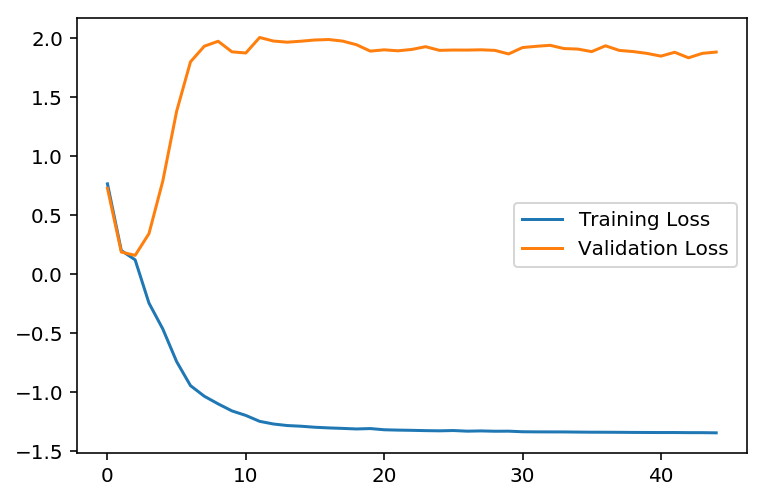

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=True)

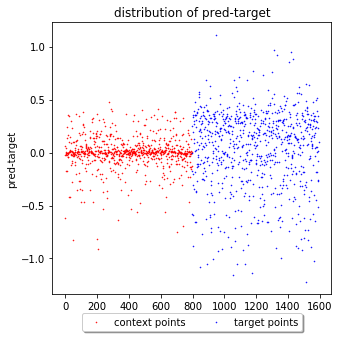

In [0]:
plt.figure(figsize=(5,5)) 
con_y = pred_y[:,:int(0.5 * test_num_total_points)] - target_y[:,:int(0.5 * test_num_total_points)]
tar_y = pred_y[:,int(0.5 * test_num_total_points):] - target_y[:,int(0.5 * test_num_total_points):]
X1 = np.arange(int(0.5 * test_num_total_points))
X2 = np.arange(int(0.5 * test_num_total_points),test_num_total_points)
s_con = plt.scatter(X1,con_y,color='red',s=0.3,label='context points')
s_tar = plt.scatter(X2,tar_y,color='blue',s=0.3,label='target points')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4)
plt.xlabel('')
plt.ylabel('pred-target')
plt.title(r'distribution of pred-target')
plt.show()

###  main (panstarrs and gaia) 

In [0]:
TRAINING_ITERATIONS = 1000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 200 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define data
batch_size = 50
print("start wrapping data...")
print("start wrapping training data...")
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)
print("finish...")
print("start wrapping testing data...")
test_query, test_target_y, test_num_total_points, test_num_context_points = pan_testdatawrap(test_norm_x, test_norm_y, pan_target_x, test_norm_x.shape[0])

# Define the loss
_, _, log_prob, LL, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)
print("finish wrapping data...")
# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _, _ = model(test_query, test_num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-3)
global_step = tf.train.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)
init = tf.initialize_all_variables()

#initialize best loss and LL
best_loss = 100000

LL_set = []
LL_set_x = []
saver = tf.train.Saver(max_to_keep=1)
# Train and plot
print("doing prediction...")
with tf.train.MonitoredTrainingSession(checkpoint_dir="./model/model.ckpt", save_checkpoint_secs=600) as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state("./model/model.ckpt")
  if ckpt and ckpt.model_checkpoint_path:
            # Restores from checkpoint
    saver.restore(sess, ckpt.model_checkpoint_path)
  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])
    
    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      pred_y, std_y, whole_query = sess.run([ mu, sigma, test_query])
      
      plt.figure(figsize=(5,5)) 
      plt.scatter(np.arange(pan_target_x.shape[0]), pred_y[:,test_norm_x.shape[0]:,:], s=0.5)
      plt.xlabel('')
      plt.ylabel('pred')
      plt.title(r'Prediction of Panstarrs')
      plt.show()
    
      print('Iteration: {}, prediction: {}'.format(it, pred_y))

start wrapping data...
start wrapping training data...
finish...
start wrapping testing data...


NameError: name 'pan_testdatawrap' is not defined

## **Evaluation**

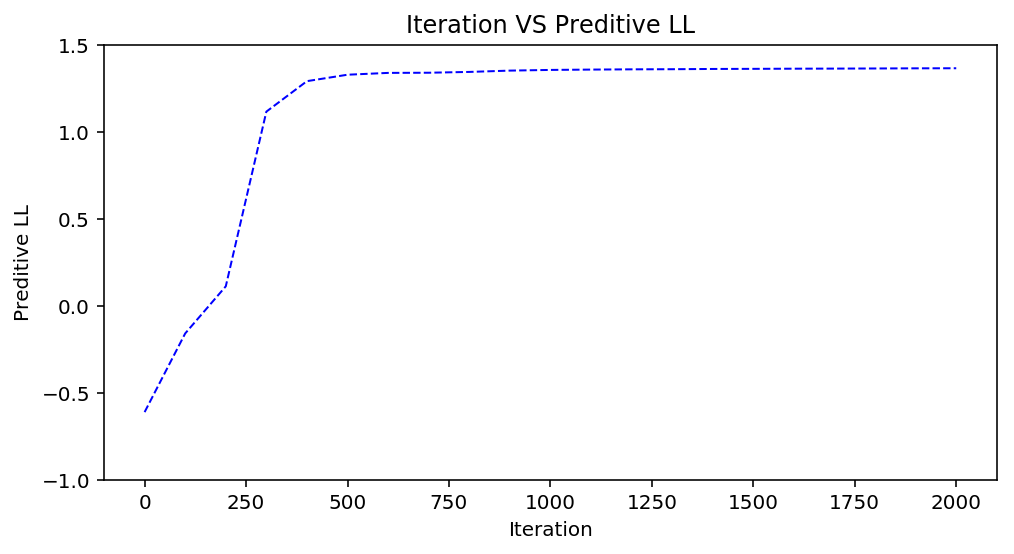

In [0]:
# LL vs itr
x = np.arange(0,2100,100)
y = LL_set
plt.figure(figsize=(8,4))
plt.plot(x, y, "b--",linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Preditive LL')
plt.title(r'Iteration VS Preditive LL')
plt.ylim(-1,1.5)
plt.show()

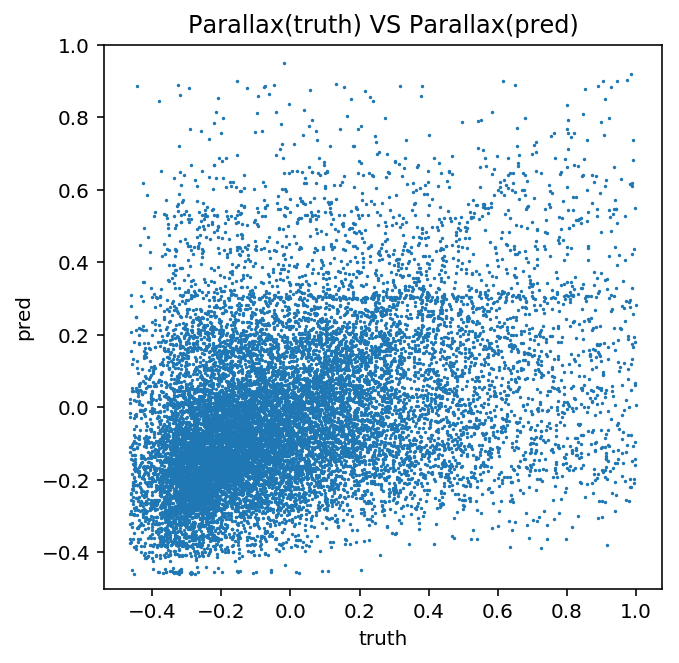

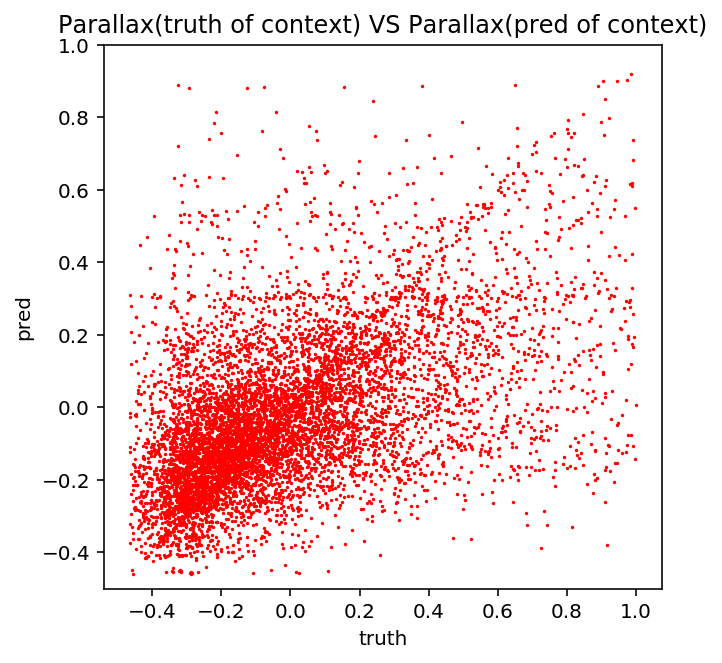

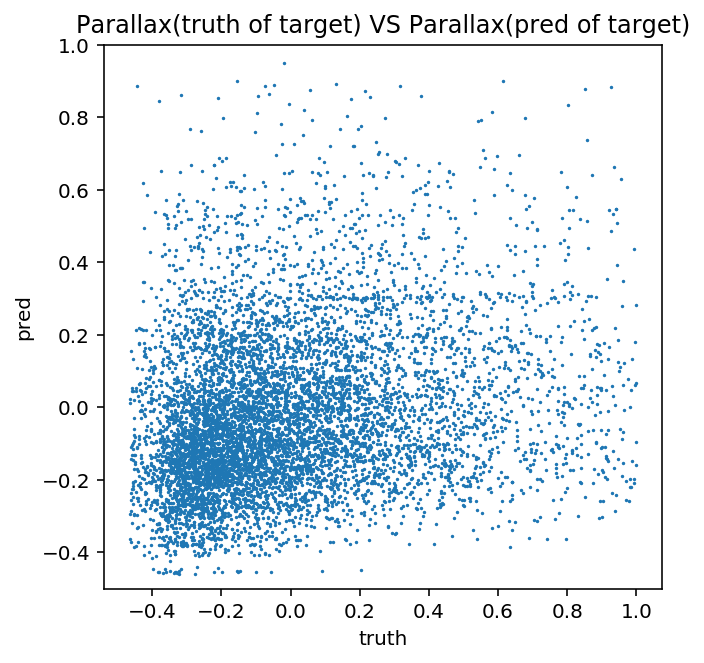

In [0]:
# ground truth vs pred (all)
plt.figure(figsize=(5,5)) 
plt.scatter(target_y, pred_y, s=0.5)
plt.xlabel('truth')
plt.ylabel('pred')
plt.ylim(-0.5,1)
plt.title(r'Parallax(truth) VS Parallax(pred)')
plt.show()

con_pred_y = pred_y[:,:int(0.5 * test_num_total_points)]
con_target_y = target_y[:,:int(0.5 * test_num_total_points)]

tar_pred_y = pred_y[:,int(0.5 * test_num_total_points):]
tar_target_y = target_y[:,int(0.5 * test_num_total_points):]
# ground truth(context) vs pred(target)
plt.figure(figsize=(5,5)) 
plt.scatter(con_target_y, con_pred_y, s=0.5,color='red')
plt.xlabel('truth')
plt.ylabel('pred')
plt.ylim(-0.5,1)
plt.title(r'Parallax(truth of context) VS Parallax(pred of context)')
plt.show()

# ground truth(context) vs pred(target)
plt.figure(figsize=(5,5)) 
plt.scatter(tar_target_y, tar_pred_y, s=0.5)
plt.xlabel('truth')
plt.ylabel('pred')
plt.ylim(-0.5,1)
plt.title(r'Parallax(truth of target) VS Parallax(pred of target)')
plt.show()


In [0]:
acc = abs(pred_y - target_y)/target_y
print(np.mean(abs(pred_y - target_y)/target_y))

0.1881524


(1, 15903, 1)


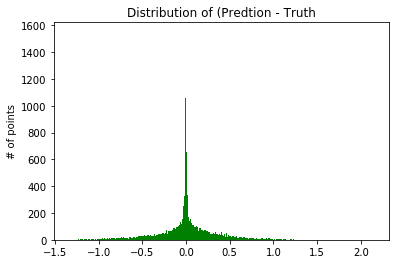

(1, 7951, 1)


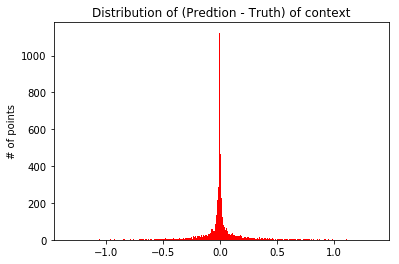

(1, 7952, 1)


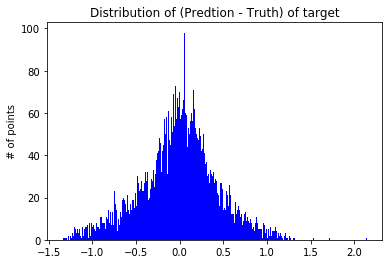

In [0]:
num_bins = 500
acc = pred_y - target_y
print(acc.shape)
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='green', alpha=1)
plt.title(r'Distribution of (Predtion - Truth')
plt.ylabel('# of points')
plt.show()

# case of context
num_bins = 500
acc = con_pred_y - con_target_y
print(acc.shape)
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='red', alpha=1)
plt.title(r'Distribution of (Predtion - Truth) of context' )
plt.ylabel('# of points')
plt.show()

# case of target
num_bins = 500
acc = tar_pred_y - tar_target_y
print(acc.shape)
n, bins, patches = plt.hist(acc[0], num_bins, facecolor='blue', alpha=1)
plt.title(r'Distribution of (Predtion - Truth) of target' )
plt.ylabel('# of points')
plt.show()

## Unwise data processing

In [0]:
# read files, would take few hours, dont run!!
from astropy.table import Table
import glob, os
print("crossing matching...34000 totoal")
unwise_df = pd.DataFrame()
os.chdir("/home/yufeng/projects/rrg-kyi/data/astro/stars/unwise/release/cat/")
count = 0
for file in glob.glob("*.fits"):
    count += 1 
    df = Table.read(file).to_pandas()
    df = df.loc[(df['ra']>=-60) & (df['ra']<=50) & (df['dec']<=0.5) & (df['dec']>=-0.5)]
    unwise_df = unwise_df.append(df)
    if count%1000==0 :
        print(count)
print("done")

In [0]:
# read csv
filename = '/home/yufeng/projects/rrg-kyi/yufeng/gaia/data/selected_wise.csv'
unwise_new_df = pd.read_csv(filename)
# add wavelength
unwise_new_df['wavelength'] = np.where(unwise_new_df['band']==1, 33526, 46028)
unwise_new_df.head()

,Unnamed: 0,x,y,flux,dx,dy,dflux,qf,rchi2,fracflux,...,ra,dec,coadd_id,band,unwise_detid,nm,primary,flags_unwise,flags_info,wavelength
0,7940,368.939900,934.901125,155.086850,0.084313,0.083965,7.537626,1.0,0.327513,0.946809,...,49.983835,-0.499998,b'0499p000',1,b'0499p000w1o0007940',121,1,0,0,33526
1,7943,369.487629,1085.276662,63.110485,0.200511,0.199685,7.236599,1.0,0.693012,0.911250,...,49.868965,-0.499580,b'0499p000',1,b'0499p000w1o0007943',125,1,0,0,33526
2,7944,369.491954,1099.625032,62.952230,0.199331,0.199811,7.128104,1.0,0.554260,0.893760,...,49.858004,-0.499577,b'0499p000',1,b'0499p000w1o0007944',130,1,0,0,33526
3,7945,369.073169,1118.810144,118.698740,0.106537,0.106234,7.256862,1.0,1.037835,0.777629,...,49.843349,-0.499896,b'0499p000',1,b'0499p000w1o0007945',133,1,0,0,33526
4,7946,369.276967,1206.702860,82.446625,0.152840,0.152952,7.176266,1.0,0.678155,0.787403,...,49.776209,-0.499740,b'0499p000',1,b'0499p000w1o0007946',129,1,0,0,33526


In [0]:
import math
# select the attributes
selectedf = ['ra', 'dec', 'flux', 'wavelength']
unwise_selected_df = unwise_new_df.loc[:, selectedf]

#drop row with flux < 0
indexNames = unwise_selected_df[unwise_selected_df['flux'] < 0].index
unwise_selected_df.drop(indexNames, inplace=True)

# convert flux into mag
# formula is mag = 22.5 - 2.5log(flux)
unwise_selected_df['flux'] = unwise_selected_df['flux'].apply(lambda x: 22.5 - (2.5*math.log10(x)))

#rename 'flux' as 'mag'
unwise_selected_df = unwise_selected_df.rename(columns={'flux':"mag"})
unwise_selected_df.head()

,ra,dec,mag,wavelength
0,49.983835,-0.499998,17.023563,33526
1,49.868965,-0.499580,17.999746,33526
2,49.858004,-0.499577,18.002472,33526
3,49.843349,-0.499896,17.313885,33526
4,49.776209,-0.499740,17.709568,33526


In [0]:
locations = np.random.choice(unwise_selected_df.shape[0],
                                 size=5000,
                                 replace=False)

unwise_target_x = Normalization(unwise_selected_df)
unwise_target_x = np.array(unwise_target_x)[locations,:]
pd.DataFrame(unwise_target_x).head()

,0,1,2,3
0,0.482233,0.614471,0.663751,0.988894
1,0.816329,0.597157,0.598845,0.694729
2,0.475729,0.398083,0.629335,0.988894
3,0.883319,0.617410,0.666265,0.694729
4,0.630754,0.692112,0.627393,0.988894


### Main (Unwise and Gaia)

start wrapping data...
start wrapping training data...
finish...
start wrapping testing data...
finish wrapping data...
doing prediction...
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9000 into ./model/model.ckpt/model.ckpt.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt/model.ckpt-9000
INFO:tensorflow:global_step/sec: 1189.45


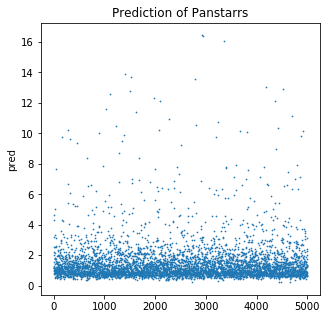

Iteration: 0, prediction: [[[0.7057487 ]
  [1.304362  ]
  [1.2412374 ]
  ...
  [1.287974  ]
  [0.83102643]
  [1.2012416 ]]]
INFO:tensorflow:global_step/sec: 1.67202
INFO:tensorflow:global_step/sec: 1.64257


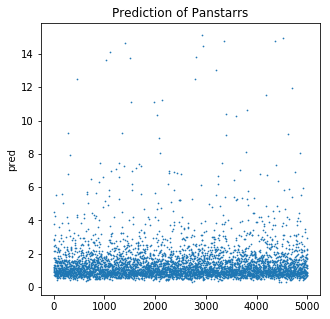

Iteration: 200, prediction: [[[0.6556786 ]
  [0.82460713]
  [1.0306877 ]
  ...
  [1.2720499 ]
  [0.82621217]
  [1.1271261 ]]]
INFO:tensorflow:global_step/sec: 1.75346
INFO:tensorflow:global_step/sec: 1.79444


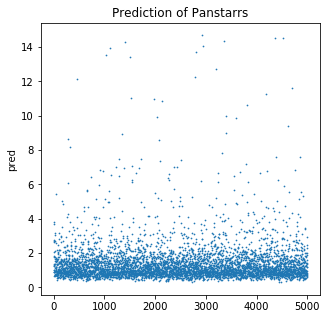

Iteration: 400, prediction: [[[0.66037387]
  [0.8253858 ]
  [1.0784583 ]
  ...
  [1.4000697 ]
  [0.8001601 ]
  [1.1781425 ]]]
INFO:tensorflow:global_step/sec: 1.76394
INFO:tensorflow:global_step/sec: 1.82296


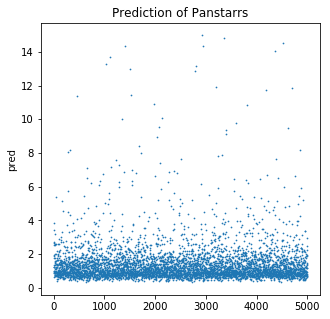

Iteration: 600, prediction: [[[0.67527956]
  [0.83918536]
  [1.0467778 ]
  ...
  [1.3757324 ]
  [0.7798922 ]
  [1.1855836 ]]]
INFO:tensorflow:global_step/sec: 1.7846
INFO:tensorflow:global_step/sec: 1.81302


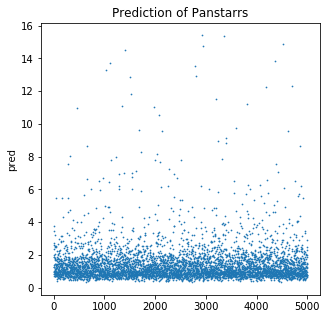

Iteration: 800, prediction: [[[0.67077714]
  [0.8577742 ]
  [1.0431348 ]
  ...
  [1.4327626 ]
  [0.7708601 ]
  [1.2285135 ]]]
INFO:tensorflow:global_step/sec: 1.65386
INFO:tensorflow:Saving checkpoints for 10000 into ./model/model.ckpt/model.ckpt.


In [0]:
TRAINING_ITERATIONS = 1000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 200 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
MODEL_TYPE = 'ANP' #@param ['NP','ANP']
ATTENTION_TYPE = 'multihead' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

tf.reset_default_graph()

# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
latent_encoder_output_sizes = [HIDDEN_SIZE]*4
num_latents = HIDDEN_SIZE
deterministic_encoder_output_sizes= [HIDDEN_SIZE]*4
decoder_output_sizes = [HIDDEN_SIZE]*2 + [2]
use_deterministic_path = True

# ANP with multihead attention
if MODEL_TYPE == 'ANP':
  attention = Attention(rep='mlp', output_sizes=[HIDDEN_SIZE]*2, 
                        att_type='multihead')
# NP - equivalent to uniform attention
elif MODEL_TYPE == 'NP':
  attention = Attention(rep='identity', output_sizes=None, att_type='uniform')
else:
  raise NameError("MODEL_TYPE not among ['ANP,'NP']")

# Define the model
model = LatentModel(latent_encoder_output_sizes, num_latents,
                    decoder_output_sizes, use_deterministic_path, 
                    deterministic_encoder_output_sizes, attention)

# Define data
batch_size = 50
print("start wrapping data...")
print("start wrapping training data...")
train_query, train_target_y, train_num_total_points, train_num_context_points = datawrap(train_norm_x, train_norm_y, batch_size)
print("finish...")
print("start wrapping testing data...")
test_query, test_target_y, test_num_total_points, test_num_context_points = pan_testdatawrap(test_norm_x, test_norm_y, unwise_target_x, test_norm_x.shape[0])

# Define the loss
_, _, log_prob, LL, _, loss = model(train_query, train_num_total_points,
                                 train_target_y)
print("finish wrapping data...")
# Get the predicted mean and variance at the target points for the testing set
mu, sigma, _, _, _, _ = model(test_query, test_num_total_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
global_step = tf.train.get_or_create_global_step()
train_step = optimizer.minimize(loss, global_step=global_step)
init = tf.initialize_all_variables()

#initialize best loss and LL
best_loss = 100000

LL_set = []
LL_set_x = []
saver = tf.train.Saver(max_to_keep=1)
# Train and plot
print("doing prediction...")
with tf.train.MonitoredTrainingSession(checkpoint_dir="./model/model.ckpt", save_checkpoint_secs=600) as sess:
  sess.run(init)
  ckpt = tf.train.get_checkpoint_state("./model/model.ckpt")
  if ckpt and ckpt.model_checkpoint_path:
            # Restores from checkpoint
    saver.restore(sess, ckpt.model_checkpoint_path)
  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])
    
    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      pred_y, std_y, whole_query = sess.run([ mu, sigma, test_query])
      
      plt.figure(figsize=(5,5)) 
      plt.scatter(np.arange(pan_target_x.shape[0]), pred_y[:,test_norm_x.shape[0]:,:], s=0.5)
      plt.xlabel('')
      plt.ylabel('pred')
      plt.title(r'Prediction of Panstarrs')
      plt.show()
    
      print('Iteration: {}, prediction: {}'.format(it, pred_y))